# SDXL Image Enhancement for Product Images (With Text)

In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Unins

In [2]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-hoaa17im
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-hoaa17im
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.8 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=6ca27f1906e9ed02858c9602be4bcdce7c51b105440a7dfb34182ab3b9ff1b0e
  Stored in directory: /tmp/pip-ephem-wheel-cache-khb716kz/wheels/3f/7c/a4/9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip


In [3]:
!pip install pytesseract Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 54.0 MB/s eta 0:00:00


## Import Libraries

In [4]:
import os
from PIL import Image
import torch
from diffusers import StableDiffusionXLImg2ImgPipeline
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from torchmetrics.functional import peak_signal_noise_ratio as psnr
from torchmetrics.functional import structural_similarity_index_measure as ssim
import torchvision.transforms.functional as TF
import clip
from torch.nn import CosineSimilarity
# For OCR evaluation
try:
    import pytesseract
    from Levenshtein import distance as levenshtein_distance
    OCR_AVAILABLE = True
except ImportError:
    print("Warning: pytesseract or Levenshtein not available. OCR evaluation will be disabled.")
    OCR_AVAILABLE = False

## Set Up File Paths

In [5]:
# Mounting to Drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Paths to original images (without text)
with_text_dir = '/content/drive/MyDrive/images_with_text'

# Function to upload the images
def images_upload(folder):
    images, filenames = [], sorted(os.listdir(folder))
    for filename in filenames:
        image_path = os.path.join(folder, filename)
        image = Image.open(image_path).convert('RGB')
        images.append(image)
    return images, filenames

images_with_text, filenames_with_text = images_upload(with_text_dir)

print(f"Downloaded {len(images_with_text)} images with text.")

Mounted at /content/drive
Downloaded 4 images with text.


In [6]:
# Output directory
output_dir = '/content/drive/MyDrive/sdxl_output_with_text'

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Verify that the directory exists
if not os.path.exists(with_text_dir):
    print(f"Warning: Directory {with_text_dir} does not exist!")
else:
    print(f"Found directory: {with_text_dir}")
    files = os.listdir(with_text_dir)
    print(f"  Contains {len(files)} files")
    if files:
        print(f"  Sample files: {', '.join(files[:3])}{'...' if len(files) > 3 else ''}")

Found directory: /content/drive/MyDrive/images_with_text
  Contains 4 files
  Sample files: 5.jpg, 6.jpg, 7.jpg...


## Initialize SDXL

In [7]:
# Check GPU availability and set device accordingly
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda":
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU detected, using CPU. This will be very slow!")

# Initialize SDXL model (Image-to-Image)
torch_dtype = torch.float16 if device == "cuda" else torch.float32

pipe = StableDiffusionXLImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    torch_dtype=torch_dtype,
    use_safetensors=True
).to(device)

Using GPU: NVIDIA A100-SXM4-40GB


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/9.04G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.78G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

## Initialize CLIP Model for Evaluation

In [8]:
# Initialize CLIP model
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 143MiB/s]


## Define Utility Functions

In [9]:
# Function to load images
def images_upload(folder):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_path = os.path.join(folder, filename)
            try:
                image = Image.open(image_path).convert('RGB')
                images.append(image)
                filenames.append(filename)
            except Exception as e:
                print(f"Error loading {filename}: {e}")
    return images, filenames

# Function to resize images by half
def resize(images, scale_factor=0.5):
    resized_images = []
    for img in images:
        width, height = img.size
        new_size = (int(width * scale_factor), int(height * scale_factor))
        resized_image = img.resize(new_size, Image.Resampling.LANCZOS)
        resized_images.append(resized_image)
    return resized_images

# Function to calculate CLIP similarity score
def calculate_clip_similarity(image1, image2):
    # Preprocess images for CLIP
    image1_preprocessed = clip_preprocess(image1).unsqueeze(0).to(device)
    image2_preprocessed = clip_preprocess(image2).unsqueeze(0).to(device)

    # Get image features
    with torch.no_grad():
        image1_features = clip_model.encode_image(image1_preprocessed)
        image2_features = clip_model.encode_image(image2_preprocessed)

    # Normalize features
    image1_features = image1_features / image1_features.norm(dim=-1, keepdim=True)
    image2_features = image2_features / image2_features.norm(dim=-1, keepdim=True)

    # Calculate cosine similarity
    similarity = torch.nn.functional.cosine_similarity(image1_features, image2_features).item()

    return similarity

# Function to calculate prompt-image CLIP similarity
def calculate_prompt_image_similarity(prompt, image):
    # Preprocess image for CLIP
    image_preprocessed = clip_preprocess(image).unsqueeze(0).to(device)

    # Tokenize text
    text = clip.tokenize([prompt]).to(device)

    # Get features
    with torch.no_grad():
        image_features = clip_model.encode_image(image_preprocessed)
        text_features = clip_model.encode_text(text)

    # Normalize features
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    # Calculate cosine similarity
    similarity = torch.nn.functional.cosine_similarity(image_features, text_features).item()

    return similarity

# Function to extract text using OCR
def extract_text(image):
    if not OCR_AVAILABLE:
        return ""
    try:
        # Extract text using pytesseract
        text = pytesseract.image_to_string(image)
        return text.strip()
    except Exception as e:
        print(f"Error in OCR: {e}")
        return ""

# Function to compare text between images using Levenshtein distance
def compare_text_similarity(img1, img2):
    if not OCR_AVAILABLE:
        return 0.0

    text1 = extract_text(img1)
    text2 = extract_text(img2)

    if not text1 and not text2:
        return 1.0  # Both have no text, perfect match
    if not text1 or not text2:
        return 0.0  # One has text, the other doesn't

    # Calculate Levenshtein distance and normalize
    max_len = max(len(text1), len(text2))
    if max_len == 0:
        return 1.0

    dist = levenshtein_distance(text1, text2)
    similarity = 1.0 - (dist / max_len)

    return max(0.0, similarity)  # Ensure non-negative

## Predefined Prompts for Product Images with Text

In [10]:
# Individual prompts for each image (from SD code)
prompts_with_text = [
    "a Chupa Chups orange sparkling soda can, vibrant orange and yellow colors, surrounded by juicy orange slices on the label, placed on a wooden surface with warm lighting, summer vibe, droplets on the can",
    "a can of Coca-Cola Zero, black with red and white logo, covered in condensation, placed on a glossy black surface with water droplets, dramatic lighting, dark moody studio background, high contrast",
    "a classic blue Pepsi soda can with red, white, and blue logo, minimal blue background, clean studio setting, top view angle, bright soft lighting, smooth shadows",
    "a Sidral Mundet apple soda can with a large red apple on the label, Mexican branding, condensation droplets on the can, dark black background with subtle reflections, product photography style, rich red tones"
]

## SDXL Image Generation

In [11]:
# Generate SDXL images with predefined prompts
def generate_sdxl(images, prompts, filenames, strength=0.5, guidance_scale=3, save_dir=None):
    sdxl_images = []

    # Ensure we have enough prompts
    if len(prompts) < len(images):
        # Repeat the prompts if needed
        prompts = prompts * (len(images) // len(prompts) + 1)
        prompts = prompts[:len(images)]

    for i, (img, prompt, filename) in enumerate(zip(images, prompts, filenames)):
        print(f"Processing image {i+1}/{len(images)}: {filename}")
        print(f"Prompt: {prompt}")
        # Count approximate tokens
        word_count = len(prompt.split())
        print(f"Word count: {word_count}")

        img = img.convert("RGB")
        try:
            result = pipe(
                prompt=prompt,
                image=img,
                strength=strength,
                guidance_scale=guidance_scale,
            ).images[0]

            sdxl_images.append(result)

            # Save the result immediately if a save directory is provided
            if save_dir:
                base_name = os.path.splitext(filename)[0]
                result.save(os.path.join(save_dir, f'enhanced_{base_name}.png'))
                print(f"Saved as: enhanced_{base_name}.png")

        except Exception as e:
            print(f"Error processing {filename}: {e}")
            # Append the original image as a fallback
            sdxl_images.append(img)

        print("---")

    return sdxl_images

## Process Images

In [12]:
# Load product images with text
print("Loading product images with text...")
images_with_text, filenames_with_text = images_upload(with_text_dir)

if len(images_with_text) > 0:
    print(f"Loaded {len(images_with_text)} product images")

    # Resize images
    print("Resizing product images...")
    resized_with_text = resize(images_with_text)

    # Generate enhanced images
    print("\nGenerating SDXL enhanced images...")
    sdxl_with_text = generate_sdxl(resized_with_text, prompts_with_text, filenames_with_text,
                               strength=0.3, guidance_scale=3, save_dir=output_dir)
else:
    print("No images found in the product directory!")

Loading product images with text...
Loaded 4 product images
Resizing product images...

Generating SDXL enhanced images...
Processing image 1/4: 5.jpg
Prompt: a Chupa Chups orange sparkling soda can, vibrant orange and yellow colors, surrounded by juicy orange slices on the label, placed on a wooden surface with warm lighting, summer vibe, droplets on the can
Word count: 34


  0%|          | 0/15 [00:00<?, ?it/s]

Saved as: enhanced_5.png
---
Processing image 2/4: 6.jpg
Prompt: a can of Coca-Cola Zero, black with red and white logo, covered in condensation, placed on a glossy black surface with water droplets, dramatic lighting, dark moody studio background, high contrast
Word count: 31


  0%|          | 0/15 [00:00<?, ?it/s]

Saved as: enhanced_6.png
---
Processing image 3/4: 7.jpg
Prompt: a classic blue Pepsi soda can with red, white, and blue logo, minimal blue background, clean studio setting, top view angle, bright soft lighting, smooth shadows
Word count: 26


  0%|          | 0/15 [00:00<?, ?it/s]

Saved as: enhanced_7.png
---
Processing image 4/4: 8.jpg
Prompt: a Sidral Mundet apple soda can with a large red apple on the label, Mexican branding, condensation droplets on the can, dark black background with subtle reflections, product photography style, rich red tones
Word count: 33
Error processing 8.jpg: CUDA out of memory. Tried to allocate 7.05 GiB. GPU 0 has a total capacity of 39.56 GiB of which 2.96 GiB is free. Process 3380 has 36.59 GiB memory in use. Of the allocated memory 34.56 GiB is allocated by PyTorch, and 1.53 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
---


## Evaluate Results with Multiple Metrics

In [13]:
# Function to calculate all metrics for image comparison
def calculate_metrics(original_imgs, generated_imgs, prompts):
    metrics = []

    for i, (orig, gen, prompt) in enumerate(zip(original_imgs, generated_imgs, prompts)):
        # Resize original to match generated if needed
        if orig.size != gen.size:
            orig = orig.resize(gen.size, Image.Resampling.LANCZOS)

        # Convert to tensors for PSNR and SSIM
        orig_tensor = TF.to_tensor(orig).unsqueeze(0)
        gen_tensor = TF.to_tensor(gen).unsqueeze(0)

        # Calculate PSNR and SSIM
        psnr_value = psnr(gen_tensor, orig_tensor).item()
        ssim_value = ssim(gen_tensor, orig_tensor).item()

        # Calculate CLIP similarity between original and generated
        clip_sim = calculate_clip_similarity(orig, gen)

        # Calculate CLIP similarity between prompt and generated image
        prompt_img_sim = calculate_prompt_image_similarity(prompt, gen)

        # Calculate text similarity using OCR if available
        text_sim = compare_text_similarity(orig, gen) if OCR_AVAILABLE else None

        metrics_dict = {
            'psnr': psnr_value,
            'ssim': ssim_value,
            'clip_img_similarity': clip_sim,
            'prompt_img_similarity': prompt_img_sim
        }

        if text_sim is not None:
            metrics_dict['text_similarity'] = text_sim

        metrics.append(metrics_dict)

    return metrics

In [14]:
# Calculate metrics for product images with text
if 'sdxl_with_text' in locals() and len(sdxl_with_text) > 0:
    metrics_with_text = calculate_metrics(
        resized_with_text,
        sdxl_with_text,
        prompts_with_text[:len(sdxl_with_text)]
    )

    # Print average metrics
    avg_psnr = sum(m['psnr'] for m in metrics_with_text) / len(metrics_with_text)
    avg_ssim = sum(m['ssim'] for m in metrics_with_text) / len(metrics_with_text)
    avg_clip_sim = sum(m['clip_img_similarity'] for m in metrics_with_text) / len(metrics_with_text)
    avg_prompt_sim = sum(m['prompt_img_similarity'] for m in metrics_with_text) / len(metrics_with_text)

    print(f"Average PSNR: {avg_psnr:.2f}")
    print(f"Average SSIM: {avg_ssim:.3f}")
    print(f"Average CLIP Image Similarity: {avg_clip_sim:.3f}")
    print(f"Average Prompt-Image Similarity: {avg_prompt_sim:.3f}")

    # Print text similarity if available
    if OCR_AVAILABLE and 'text_similarity' in metrics_with_text[0]:
        avg_text_sim = sum(m['text_similarity'] for m in metrics_with_text) / len(metrics_with_text)
        print(f"Average Text Similarity (OCR): {avg_text_sim:.3f}")

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `peak_signal_noise_ratio` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `peak_signal_noise_ratio` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `peak_signal_noise_ratio` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `peak_signal_noise_ratio` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torch

Average PSNR: inf
Average SSIM: 0.831
Average CLIP Image Similarity: 0.979
Average Prompt-Image Similarity: 0.373
Average Text Similarity (OCR): 1.000


## Visualize Results

In [15]:
# Function for visualizing results with all metrics
def visualize_results(original_images, enhanced_images, filenames, metrics, prompts, num_images=None):
    if num_images is None:
        num_images = len(original_images)
    else:
        num_images = min(num_images, len(original_images))

    plt.figure(figsize=(20, 6 * num_images))

    for i in range(num_images):
        # Original image
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(original_images[i])
        plt.title(f'Original: {filenames[i]}')
        plt.axis('off')

        # Enhanced image with metrics
        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(enhanced_images[i])

        # Create metrics string
        metrics_str = (f"PSNR: {metrics[i]['psnr']:.2f}, SSIM: {metrics[i]['ssim']:.3f}\n"
                      f"CLIP Img Sim: {metrics[i]['clip_img_similarity']:.3f}, "
                      f"Prompt-Img Sim: {metrics[i]['prompt_img_similarity']:.3f}")

        # Add text similarity if available
        if 'text_similarity' in metrics[i]:
            metrics_str += f"\nText Sim (OCR): {metrics[i]['text_similarity']:.3f}"

        plt.title(f"Enhanced {filenames[i]}\n{metrics_str}\nPrompt: {prompts[i][:50]}...")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

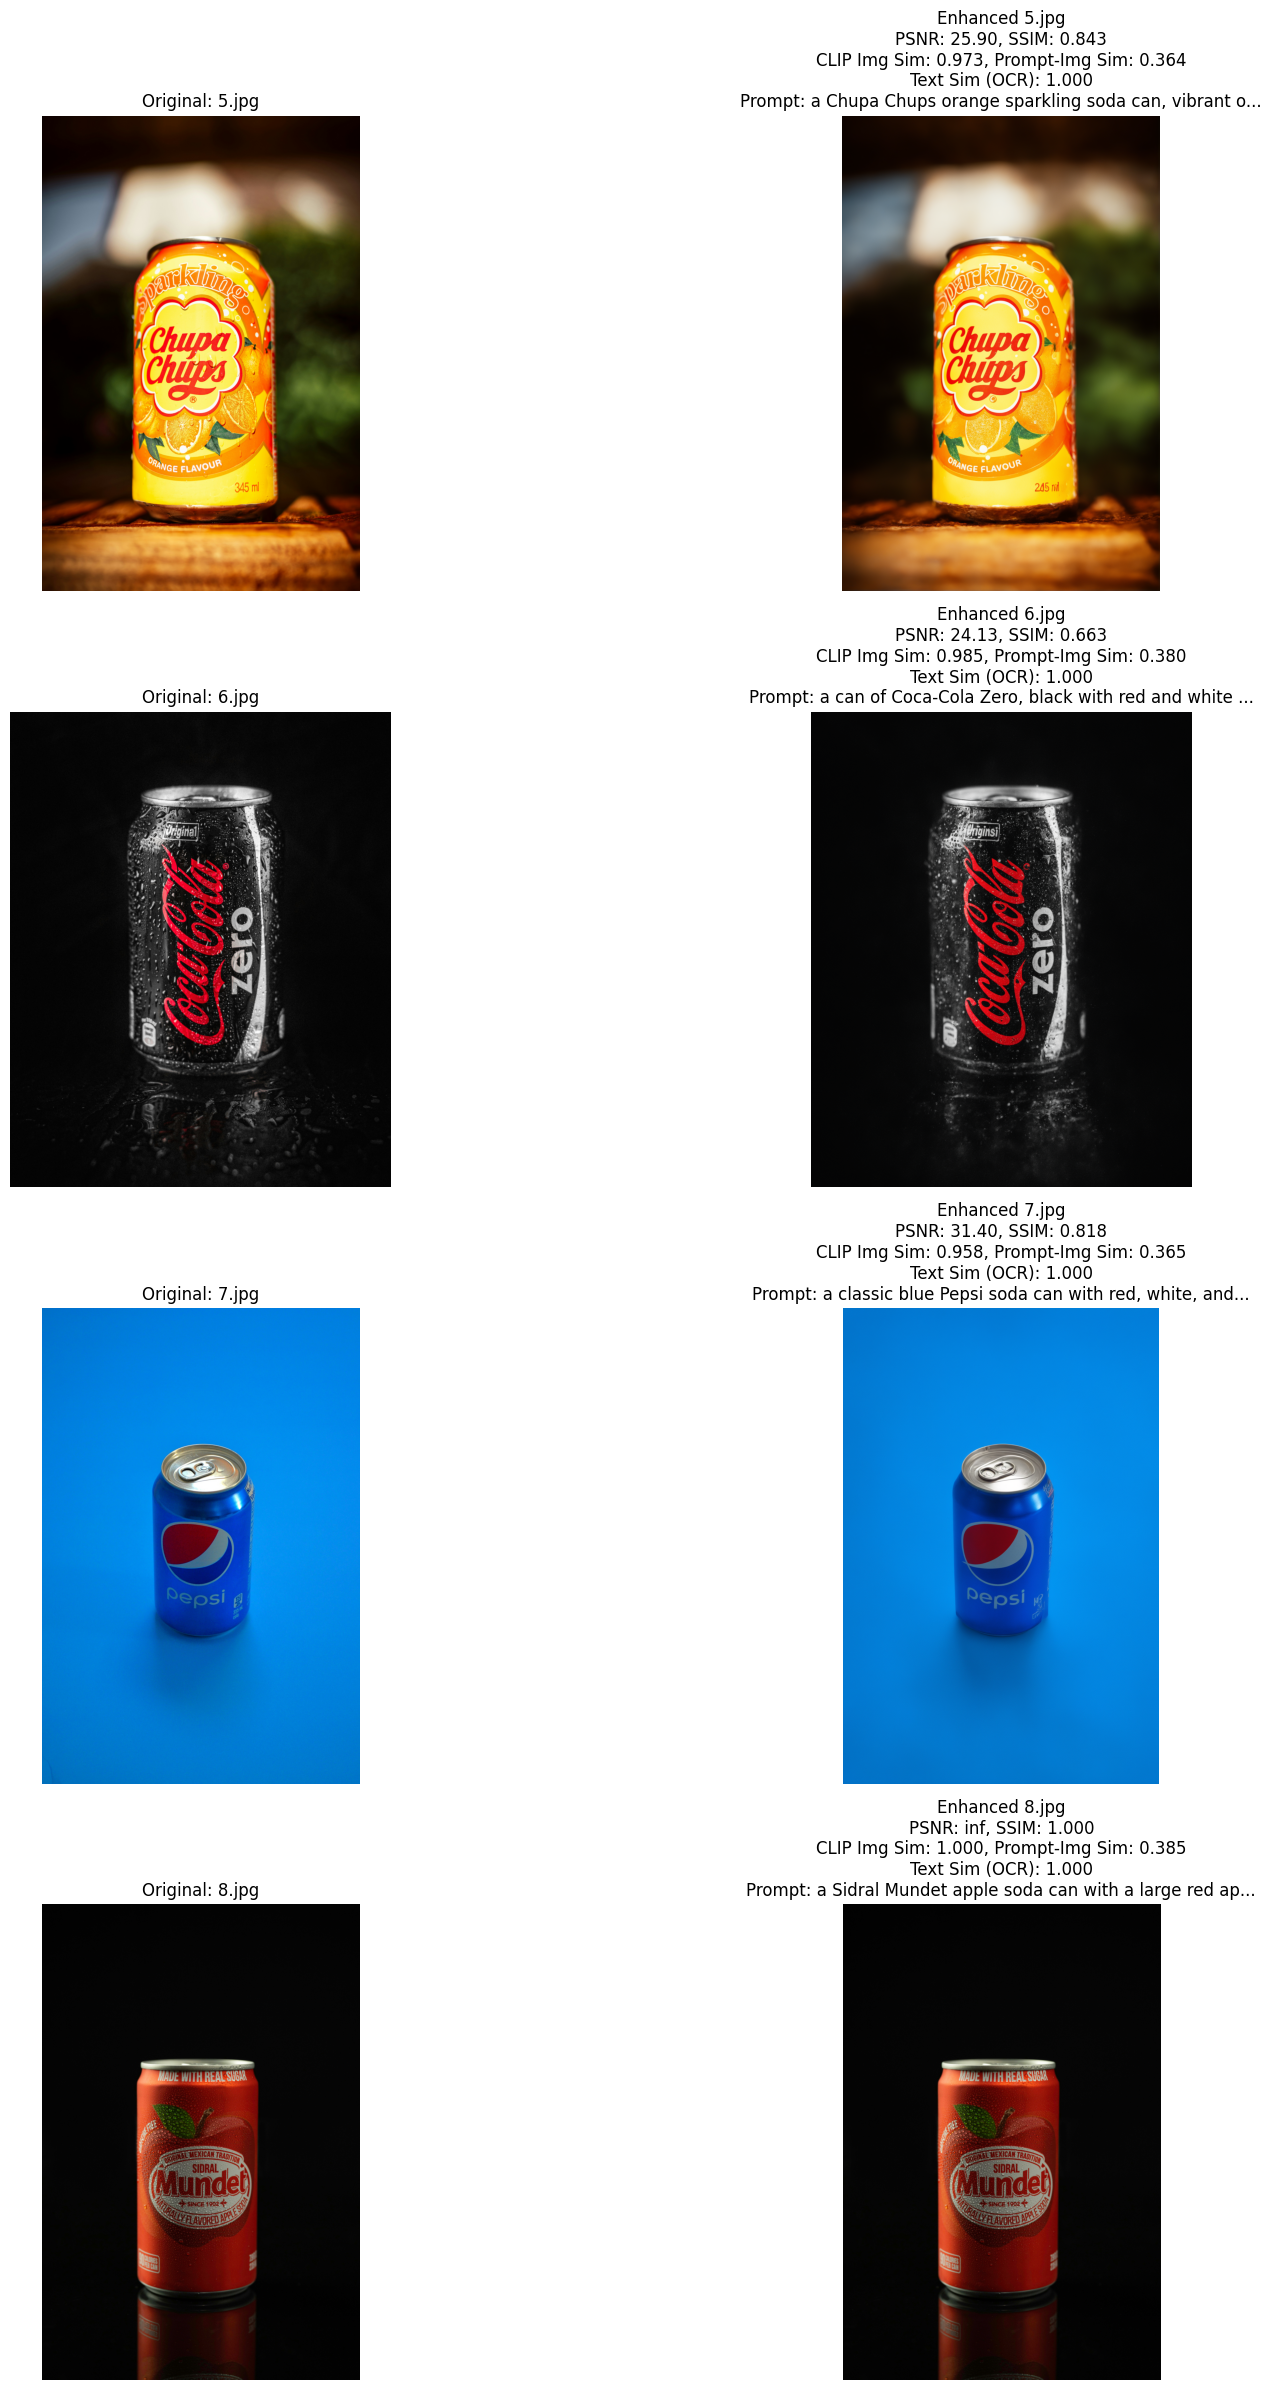

In [16]:
# Visualize product image results
if 'sdxl_with_text' in locals() and len(sdxl_with_text) > 0:
    visualize_results(
        resized_with_text,
        sdxl_with_text,
        filenames_with_text,
        metrics_with_text,
        prompts_with_text[:len(sdxl_with_text)],
        num_images=5  # Adjust as needed
    )

## Summary of Enhanced Images

In [17]:
# Count and list enhanced images
enhanced_files = [f for f in os.listdir(output_dir) if f.startswith('enhanced_')]
print(f"Total enhanced product images saved: {len(enhanced_files)}")
print(f"Output directory: {os.path.abspath(output_dir)}")

if enhanced_files:
    print("\nSample of enhanced images:")
    for file in enhanced_files[:5]:  # Show first 5
        print(f"- {file}")
    if len(enhanced_files) > 5:
        print(f"...and {len(enhanced_files) - 5} more")

Total enhanced product images saved: 3
Output directory: /content/sdxl_output_with_text

Sample of enhanced images:
- enhanced_5.png
- enhanced_6.png
- enhanced_7.png


## Additional Text Preservation Analysis

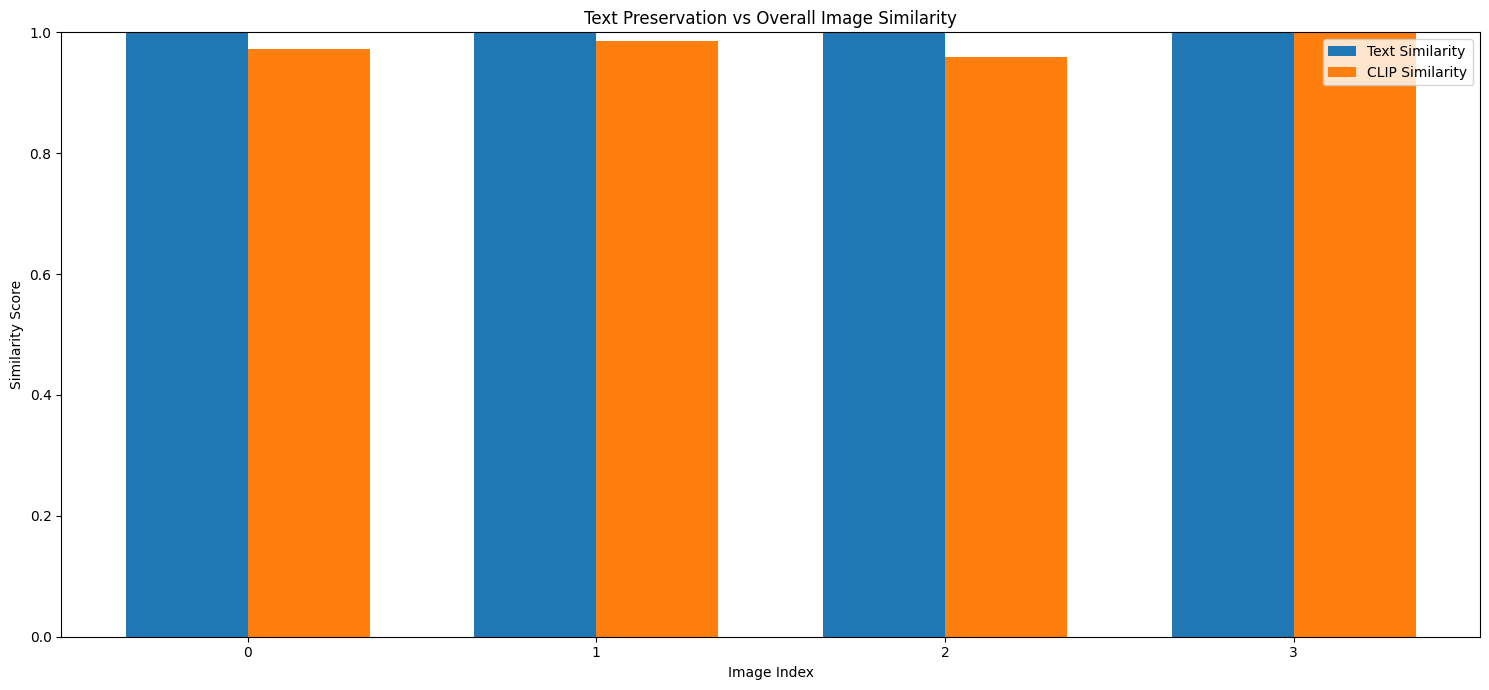


Text Preservation Analysis:
Images with poor text preservation (similarity < 0.3): None
Images with good text preservation (similarity >= 0.7): [0, 1, 2, 3]
Overall text quality assessment: Good (avg: 1.00)


In [18]:
# Additional analysis specifically for text preservation
if OCR_AVAILABLE and 'sdxl_with_text' in locals() and len(sdxl_with_text) > 0:
    plt.figure(figsize=(15, 7))

    # Prepare data for the plot
    image_indices = list(range(len(metrics_with_text)))
    text_similarities = [m.get('text_similarity', 0) for m in metrics_with_text]
    clip_similarities = [m['clip_img_similarity'] for m in metrics_with_text]

    # Create bar chart
    bar_width = 0.35
    plt.bar([i - bar_width/2 for i in image_indices], text_similarities, bar_width, label='Text Similarity')
    plt.bar([i + bar_width/2 for i in image_indices], clip_similarities, bar_width, label='CLIP Similarity')

    plt.xlabel('Image Index')
    plt.ylabel('Similarity Score')
    plt.title('Text Preservation vs Overall Image Similarity')
    plt.xticks(image_indices, [f"{i}" for i in image_indices])
    plt.legend()
    plt.ylim(0, 1.0)

    plt.tight_layout()
    plt.show()

    # Print a summary of text preservation
    poor_text = [i for i, m in enumerate(metrics_with_text) if m.get('text_similarity', 0) < 0.3]
    good_text = [i for i, m in enumerate(metrics_with_text) if m.get('text_similarity', 0) >= 0.7]

    print("\nText Preservation Analysis:")
    print(f"Images with poor text preservation (similarity < 0.3): {poor_text if poor_text else 'None'}")
    print(f"Images with good text preservation (similarity >= 0.7): {good_text if good_text else 'None'}")
    print(f"Overall text quality assessment: {'Good' if avg_text_sim >= 0.5 else 'Poor'} (avg: {avg_text_sim:.2f})")